In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

C:\Users\austi\miniconda3\envs\deep_learn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Preprocessing code from
https://www.kaggle.com/code/phamvanvung/cmapss

In [12]:
class CMAPSSTrainDataset(Dataset):
    def __init__(self, dataset_no=1):
        ragged_data = []
        X_train, y_train = self.load_split_datasets(dataset_no)
        for i in range(len(X_train)):
            for j in range(len(X_train[i])):
                ragged_data.append([np.array(X_train[i][j]), np.array(y_train[i][j])])
                
        del X_train
        sequenced_data = self.sequence_data(ragged_data)
        del ragged_data
        
        self.pad_len = 542 # max of any sequence from any dataset
        
        self.data = []
        for X, y in sequenced_data:
            padded_X = np.pad(X, ((0, self.pad_len-X.shape[0]), (0,0)))
            self.data.append([padded_X, y])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sensors, rul = self.data[idx]
        return torch.from_numpy(sensors), rul
    
    def sequence_data(self, ragged_data):
        sequenced_data = []
        for X, y in ragged_data:
            prev_rul = y[0]
            i = 0
            for rul in y:
                if prev_rul == 0:
                    break
                prev_rul = rul
                sequenced_data.append([X[:i], rul])
                i += 1

        return sequenced_data
    
    def load_split_datasets(self, dataset_no):
        dataPath = '../CMAPSSData'
        id_col = ['id']
        cycle_col = ['cycle']
        setting_cols = ['setting1', 'setting2', 'setting3']
        sensor_cols = ['sensor' + str(i) for i in range(1, 22)]
        rul_col = ['RUL']
        all_cols = id_col + cycle_col + setting_cols + sensor_cols + rul_col
        
                # This section is to load data
        def loadData(fileName):
            data = pd.read_csv(fileName, sep=" ", header=None)
            data.drop([26, 27], axis = 1, inplace=True)
            data.columns = id_col + cycle_col + setting_cols +sensor_cols
            return data
        
                # load train RUL also returns the max cycle, and this max cycle is also the life cylce
        def addTrainRul(data, decrease_threshold=None):
            lifeCycles = {mcId: data[data['id']==mcId]['cycle'].max() for mcId in data['id'].unique()}
            if decrease_threshold == None: decrease_threshold = 1
            ruls = [lifeCycles[row[0]] - decrease_threshold if row[1] < decrease_threshold else lifeCycles[row[0]] - row[1] for row in data.values]
            data['RUL'] = ruls
            return lifeCycles

        # use this last one only, return the data as well as the max life cycles
        def loadTrainData(setNumber, decrease_threshold=None):
            fileName = dataPath + '/train_FD00' + str(setNumber) + '.txt'
            data = loadData(fileName)
            lifeCycles = addTrainRul(data, decrease_threshold)
            return data, lifeCycles
        
        decrease_threshold = None
        
        train_datasets, train_lifecycles = [], []
        
        scaler = MinMaxScaler()
        setNumber = dataset_no
        train, trainLifeCycles = loadTrainData(setNumber, decrease_threshold)
        target = train['RUL'].copy()
        transformed_train = scaler.fit_transform(train)
        train = pd.DataFrame(transformed_train, columns=train.columns, index=train.index)
        train['RUL'] = target
        train_datasets.append(train)
        train_lifecycles.append(trainLifeCycles)
        
        X_train = []
        y_train = []
        
        split_data, ruls = self.split_by_id(train_datasets[0], dataset_no)
        X_train.append(split_data)
        y_train.append(ruls)
            
        return X_train, y_train
        
    def split_by_id(self, dataset, dataset_no=1):
        split_data = []
        ruls = []
        for id_no in np.unique(dataset['id']):
            split = dataset.groupby('id').get_group(id_no).copy()
            split['dataset_no'] = dataset_no
            rul = split['RUL']
            split = split.drop('RUL', axis=1)
            split_data.append(split)
            ruls.append(rul)

        return split_data, ruls

In [13]:
traindata = CMAPSSTrainDataset(dataset_no=1)
trainloader = DataLoader(traindata, batch_size=32, shuffle=False)

In [14]:
example = next(enumerate(trainloader))

In [15]:
ex_X = example[1][0]
ex_y = example[1][1]

In [16]:
ex_X.shape

torch.Size([32, 542, 27])

In [9]:
ex_y.shape

torch.Size([32])

In [10]:
ex_y

tensor([191., 190., 189., 188., 187., 186., 185., 184., 183., 182., 181., 180.,
        179., 178., 177., 176., 175., 174., 173., 172., 171., 170., 169., 168.,
        167., 166., 165., 164., 163., 162., 161., 160.], dtype=torch.float64)

In [11]:
ex_X[2][:,18]

tensor([0.1996, 0.1628, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [6]:
class CMAPSSTestDataset(Dataset):
    def __init__(self, size, dataset_no=1):
        ragged_data = []
        X_test, y_test = self.load_split_datasets(dataset_no)
        for i in range(len(X_test)):
            for j in range(len(X_test[i])):
                ragged_data.append([np.array(X_test[i][j]), np.array(y_test[i][j])])
                
        del X_test
        sequenced_data = self.sequence_data(ragged_data)
        del ragged_data
        
        self.pad_len = size
        
        self.data = []
        for X, y in sequenced_data:
            padded_X = np.pad(X, ((0, self.pad_len-X.shape[0]), (0,0)))
            self.data.append([padded_X, y])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sensors, rul = self.data[idx]
        return torch.from_numpy(sensors), rul
    
    def sequence_data(self, ragged_data):
        sequenced_data = []
        for X, y in ragged_data:
            prev_rul = y[0]
            i = 0
            for rul in y:
                if prev_rul == 0:
                    break
                prev_rul = rul
                sequenced_data.append([X[:i], rul])
                i += 1

        return sequenced_data
    
    def load_split_datasets(self, setNumber):
        dataPath = '../CMAPSSData'
        id_col = ['id']
        cycle_col = ['cycle']
        setting_cols = ['setting1', 'setting2', 'setting3']
        sensor_cols = ['sensor' + str(i) for i in range(1, 22)]
        rul_col = ['RUL']
        all_cols = id_col + cycle_col + setting_cols + sensor_cols + rul_col
        
                # This section is to load data
        def loadData(fileName):
            data = pd.read_csv(fileName, sep=" ", header=None)
            data.drop([26, 27], axis = 1, inplace=True)
            data.columns = id_col + cycle_col + setting_cols +sensor_cols
            return data
        
        decrease_threshold = None
        
        def loadTestRul(fileName):
            data = pd.read_csv(fileName, sep = " ", header=None)
            data.drop([1], axis=1, inplace=True)
            data.columns = ['RUL']
            return data
        def addTestRul(data, rulData, decrease_threshold=None):
            testRuls = {i+1: rulData.iloc[i, 0] for i in range(len(rulData))}
            lifeCycles = {mcId: data[data['id']==mcId]['cycle'].max() + testRuls[mcId] for mcId in data['id'].unique()}
            if decrease_threshold == None: decrease_threshold = 1
            ruls = [lifeCycles[row[0]] - decrease_threshold if row[1] < decrease_threshold else lifeCycles[row[0]] - row[1] for row in data.values]
            data['RUL'] = ruls
            return lifeCycles
        # Use this last one only => return data as well as the max life cycles for each machine
        def loadTestData(setNumber, decrease_threshold=None):
            data = loadData(dataPath + '/test_FD00' +str(setNumber)+'.txt')
            rulData = loadTestRul(dataPath + '/RUL_FD00' + str(setNumber)+'.txt')
            lifeCycles = addTestRul(data, rulData, decrease_threshold)
            return data, lifeCycles
        
        test_datasets, test_lifecycles = [], []
        
        scaler = MinMaxScaler()

        test, testLifeCycles = loadTestData(setNumber, decrease_threshold)
        print(testLifeCycles)
        target = test['RUL'].copy()
        transformed_test = scaler.fit_transform(test)
        test = pd.DataFrame(transformed_test, columns=test.columns, index=test.index)
        test['RUL'] = target
        test_datasets.append(test)
        test_lifecycles.append(testLifeCycles)
        
        X_test = []
        y_test = []

        split_data, ruls = self.split_by_id(test_datasets[0], setNumber)
        X_test.append(split_data)
        y_test.append(ruls)
#         print(y_test)
            
        return X_test, y_test
        
    def split_by_id(self, dataset, dataset_no=1):
        split_data = []
        ruls = []
        for id_no in np.unique(dataset['id']):
            split = dataset.groupby('id').get_group(id_no).copy()
            split['dataset_no'] = dataset_no
            rul = split['RUL']
            split = split.drop('RUL', axis=1)
            split_data.append(split)
            ruls.append(rul)

        return split_data, ruls

In [7]:
testdata = CMAPSSTestDataset(size=542, dataset_no=1)
testloader = DataLoader(testdata, batch_size=32, shuffle=False)

{1: 143, 2: 147, 3: 195, 4: 188, 5: 189, 6: 198, 7: 251, 8: 261, 9: 166, 10: 288, 11: 180, 12: 341, 13: 290, 14: 153, 15: 159, 16: 197, 17: 215, 18: 161, 19: 222, 20: 200, 21: 205, 22: 150, 23: 243, 24: 206, 25: 193, 26: 195, 27: 206, 28: 255, 29: 261, 30: 258, 31: 204, 32: 193, 33: 156, 34: 210, 35: 209, 36: 145, 37: 142, 38: 175, 39: 179, 40: 161, 41: 141, 42: 166, 43: 231, 44: 163, 45: 266, 46: 193, 47: 208, 48: 170, 49: 324, 50: 153, 51: 258, 52: 218, 53: 190, 54: 218, 55: 250, 56: 151, 57: 263, 58: 213, 59: 208, 60: 247, 61: 180, 62: 286, 63: 227, 64: 196, 65: 199, 66: 161, 67: 148, 68: 195, 69: 175, 70: 246, 71: 186, 72: 181, 73: 243, 74: 263, 75: 201, 76: 215, 77: 196, 78: 179, 79: 164, 80: 223, 81: 221, 82: 171, 83: 210, 84: 230, 85: 152, 86: 199, 87: 172, 88: 183, 89: 313, 90: 174, 91: 272, 92: 170, 93: 329, 94: 188, 95: 217, 96: 234, 97: 216, 98: 180, 99: 214, 100: 218}


In [ ]:
example = next(enumerate(trainloader))

In [ ]:
example_test = next(enumerate(testloader))

In [ ]:
example_test[1][0].shape

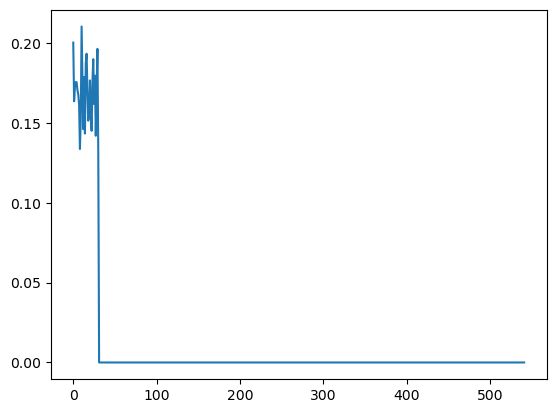

In [9]:
plt.plot(example[1][0][31].detach().numpy()[:,18])
# plt.plot(example[1][1][31].detach().numpy())